In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import csv

In [3]:
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import random
import plotly.graph_objs as go
import plotly.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='solar')

In [ ]:
path = r'C:\Users\kishore.kukreja\Downloads\listings'
file = 'listings.csv'
f = open(path+'\\'+file,'rt',encoding='utf-8')
reader = csv.reader(f)

#once contents are available, I then put them in a list
csv_list = []
for l in reader:
    csv_list.append(l)
f.close()
#now pandas has no problem getting into a df
df = pd.DataFrame(csv_list)

In [4]:
import dask.dataframe as dd

In [ ]:
df = dd.read_csv(r'C:\Users\kishore.kukreja\Downloads\listings\listings.csv', error_bad_lines=False,sep=';')

In [5]:
df=pd.read_csv(r'C:\Users\kishore.kukreja\Downloads\listings\listings.csv',sep=';',lineterminator='\n')

In [8]:
df.shape

(340208, 73)

In [9]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Summary', 'Space', 'Description',
       'Experiences_Offered', 'Neighborhood_Overview', 'Notes', 'Transit',
       'Access', 'Interaction', 'House_Rules', 'Host_Name', 'Host_Since',
       'Host_Location', 'Host_About', 'Host_Response_Time',
       'Host_Response_Rate', 'Host_Acceptance_Rate', 'Host_Neighbourhood',
       'Host_Listings_Count', 'Host_Total_Listings_Count', 'Street',
       'Neighbourhood', 'Neighbourhood_Cleansed',
       'Neighbourhood_Group_Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart_Location', 'Country_Code', 'Country', 'Latitude', 'Longitude',
       'Property_Type', 'Room_Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed_Type', 'Amenities', 'Square_Feet', 'Price', 'Weekly_Price',
       'Monthly_Price', 'Security_Deposit', 'Cleaning_Fee', 'Guests_Included',
       'Extra_People', 'Minimum_Nights', 'Maximum_Nights', 'Calendar_Updated',
       'Has_Availability', 'Availability_30', 'Availabili

In [13]:
df['type']='Train'

In [14]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [15]:
missing_in_train=missing_values_table(df)

Your selected dataframe has 74 columns.
There are 69 columns that have missing values.


In [18]:
## drop records with more than 50% of Missing Values
missing_in_train[missing_in_train['% of Total Values']>=50]

Missing Values  % of Total Values
Has_Availability                      333791               98.1
Square_Feet                           332005               97.6
License                               330006               97.0
Host_Acceptance_Rate                  310723               91.3
Monthly_Price                         286336               84.2
Weekly_Price                          285068               83.8
Neighbourhood_Group_Cleansed          268612               79.0
Jurisdiction_Names                    246012               72.3
Security_Deposit                      224433               66.0
Notes                                 204599               60.1

In [20]:
missing_in_train.reset_index(inplace=True)

In [25]:
drop_cols=np.unique(missing_in_train[missing_in_train['% of Total Values']>=50]['index'])

In [26]:
df_new=df.drop(drop_cols,axis=1)

In [27]:
df_new.shape

(340208, 64)

In [28]:
## Import test data

In [31]:
df_test=pd.read_csv(r'C:\Users\kishore.kukreja\Downloads\listings_test_send\listings_test_send.csv',sep=';',lineterminator='\n')

In [32]:
df_test.shape

(100703, 72)

In [33]:
## drop records with more than 50% of Missing Values
missing_in_test=missing_values_table(df_test)
missing_in_test[missing_in_test['% of Total Values']>=50]

Your selected dataframe has 72 columns.
There are 62 columns that have missing values.


Missing Values  % of Total Values
Has_Availability                       98698               98.0
Square_Feet                            98234               97.5
License                                97710               97.0
Host_Acceptance_Rate                   91907               91.3
Monthly_Price                          84927               84.3
Weekly_Price                           84361               83.8
Neighbourhood_Group_Cleansed           79733               79.2
Jurisdiction_Names                     72753               72.2
Security_Deposit                       66451               66.0
Notes                                  60893               60.5

In [34]:
df_new_test=df_test.drop(drop_cols,axis=1)

In [35]:
df_new_test.shape

(100703, 62)

In [39]:
df_new_test['type']='Test'

In [38]:
set(df_new.columns.values) - set(df_new_test.columns.values)

{'ID', 'Listing_Type', 'type'}

In [48]:
def prepareTrainData(csv_file):
    df=pd.read_csv(csv_file,sep=';',lineterminator='\n')
    df['type']='Train'
    missing_in_train=missing_values_table(df)
    missing_in_train.reset_index(inplace=True)
    drop_cols=np.unique(missing_in_train[missing_in_train['% of Total Values']>=50]['index'])
    df_new=df.drop(drop_cols,axis=1)
    return df_new,drop_cols

In [60]:
df_train,drop_cols=prepareTrainData(r'C:\Users\kishore.kukreja\Downloads\listings\listings.csv')

Your selected dataframe has 74 columns.
There are 69 columns that have missing values.


In [61]:
def predictListingType(csv_file,drop_cols):
    df_train,drop_cols=prepareTrainData(r'C:\Users\kishore.kukreja\Downloads\listings\listings.csv')
    df=pd.read_csv(csv_file,sep=';',lineterminator='\n')
    df['type']='Test'
    df_new=df.drop(drop_cols,axis=1)
    return df_new

In [71]:
df_test=predictListingType(r'C:\Users\kishore.kukreja\Downloads\listings_test_send\listings_test_send.csv',drop_cols)

In [72]:
set(df_train.columns)-set(df_test.columns)

{'ID', 'Listing_Type'}

In [73]:
#drop ID columns

In [74]:
print(df_train.shape)
print(df_test.shape)

(340208, 64)
(100703, 63)


In [75]:
set(df_test.columns)-set(df_train.columns)

{'GUID'}

In [76]:
df_test.rename(columns={'GUID':'ID'},inplace=True)
print(df_test.shape)
#df_test.columns.values

(100703, 63)


In [77]:
set(df_train.columns)-set(df_test.columns)

{'Listing_Type'}

In [78]:
df_total=pd.concat([df_train,df_test],axis=0)

C:\Users\kishore.kukreja\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [59]:
df_total.shape ## this is the overall data 

(440911, 63)

In [10]:
import missingno as msno

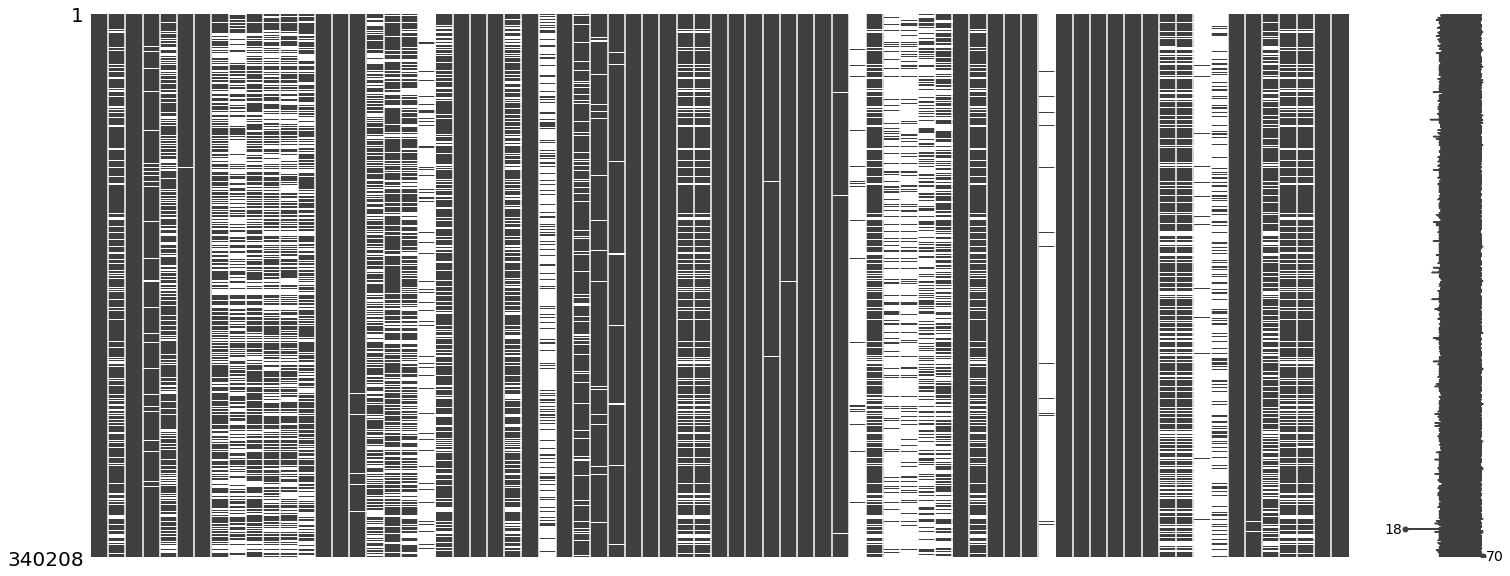

In [11]:
msno.matrix(df)

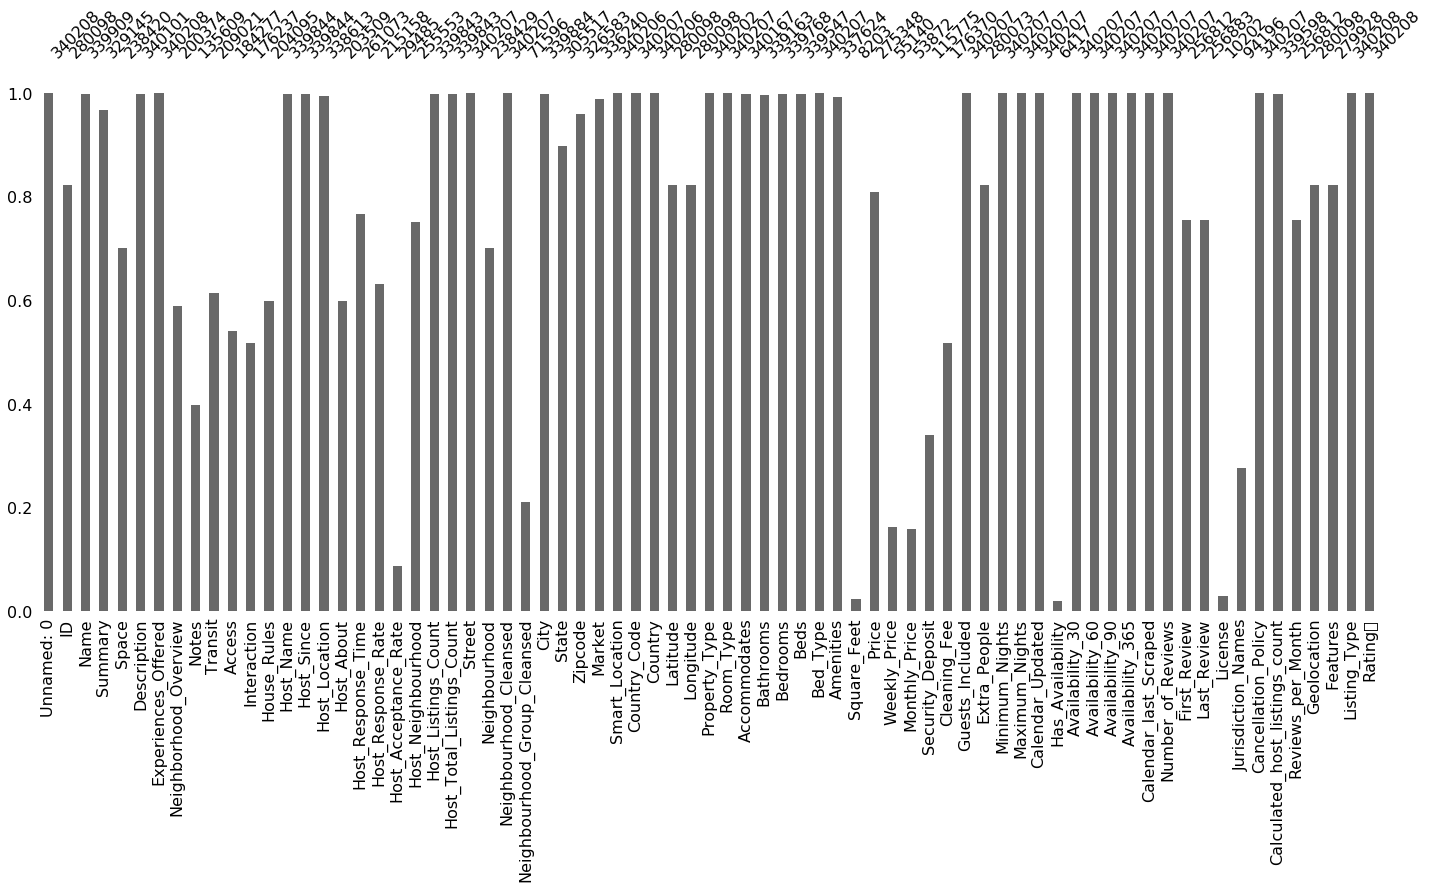

In [12]:
msno.bar(df)

In [79]:
df_total.isnull().sum(axis=0)

Access                            202297
Accommodates                          59
Amenities                           3321
Availability_30                        2
Availability_365                       2
Availability_60                        2
Availability_90                        2
Bathrooms                           1384
Bed_Type                               1
Bedrooms                             565
Beds                                 832
Calculated_host_listings_count       778
Calendar_Updated                       1
Calendar_last_Scraped                  2
Cancellation_Policy                    2
City                                 410
Cleaning_Fee                      212198
Country                                3
Country_Code                           2
Description                          136
Experiences_Offered                    0
Extra_People                       78000
Features                           78195
First_Review                      108087
Geolocation     

In [80]:
df_total['Description'].head().values ## only 107 description are null , can remove them 

array(["This apartment in the West Rogers Park (or West Ridge) neighborhood of Chicago is spacious, welcoming, cozy, and quiet.  As an additional potential perk, this apartment is toddler and child friendly! See full description for details. Thanks! Hi there traveler.  Thanks for considering staying in this quiet, low-key area of Chicago. The West Ridge neighborhood is a safe, spacious, vibrant area that would help make your trip comfortable and easy.  I am a short walk to Devon Ave, which hosts the city's widest array of Indian cuisine, so if that is something that you're interested in, you'll find amazing dinners a stone's throw away.  The apartment is itself is spacious and very private feeling, as this is the top floor of a two flat with just two other people living in the building in the downstairs unit. The room available to you is spacious, cozy, and purposely simple. This room is just off the kitchen, which is open for you to use to cook and to store your own food.  There is a 

In [81]:
df_total.columns.values

array(['Access', 'Accommodates', 'Amenities', 'Availability_30',
       'Availability_365', 'Availability_60', 'Availability_90',
       'Bathrooms', 'Bed_Type', 'Bedrooms', 'Beds',
       'Calculated_host_listings_count', 'Calendar_Updated',
       'Calendar_last_Scraped', 'Cancellation_Policy', 'City',
       'Cleaning_Fee', 'Country', 'Country_Code', 'Description',
       'Experiences_Offered', 'Extra_People', 'Features', 'First_Review',
       'Geolocation', 'Guests_Included', 'Host_About',
       'Host_Listings_Count', 'Host_Location', 'Host_Name',
       'Host_Neighbourhood', 'Host_Response_Rate', 'Host_Response_Time',
       'Host_Since', 'Host_Total_Listings_Count', 'House_Rules', 'ID',
       'Interaction', 'Last_Review', 'Latitude', 'Listing_Type',
       'Longitude', 'Market', 'Maximum_Nights', 'Minimum_Nights', 'Name',
       'Neighborhood_Overview', 'Neighbourhood', 'Neighbourhood_Cleansed',
       'Number_of_Reviews', 'Price', 'Property_Type', 'Rating\r',
       'Reviews_

In [82]:
df_total['Amenities'].head()

0    TV,Internet,Wireless Internet,Air conditioning...
1    Internet,Kitchen,Pets live on this property,Do...
2    TV,Internet,Wireless Internet,Kitchen,Heating,...
3    TV,Cable TV,Internet,Wireless Internet,Air con...
4                                                  NaN
Name: Amenities, dtype: object

In [83]:
df_total['Country'].head().values

array(['United States', 'Denmark', 'Netherlands', 'France',
       'United States'], dtype=object)

In [84]:
df_total[df_total['Country'].isnull()].shape

(3, 64)

In [85]:
df_total=df_total[~df_total['Country'].isnull()]

In [86]:
df_total['Country'].value_counts()

United States     121827
United Kingdom     55354
France             51444
Spain              41614
Australia          36989
Canada             27987
Italy              21999
Germany            18651
Denmark            18646
Netherlands        13768
Austria             7197
Belgium             6729
Ireland             6025
Hong Kong           5820
Greece              4655
Switzerland         2148
China                 47
Vatican City           2
Mexico                 2
Vanuatu                1
0                      1
Cuba                   1
Uruguay                1
Name: Country, dtype: int64

In [87]:
## remove description where null
df1=df_total[~df_total['Description'].isnull()]

In [88]:
df1.shape

(440772, 64)

In [92]:
## concat name,description and listing ;just 3 for text 
df2=df1[['Name','Description','Listing_Type','type']]

In [93]:
df2.head()

Name  \
0   Private room in sunny three bedroom   
1               Lovely & cute apartment   
2  Unique house with a beautiful garden   
3      Résidence du 14 Rue des Sablons;   
4    Darling 2 story historical spanish   

                                         Description Listing_Type   type  
0  This apartment in the West Rogers Park (or Wes...         Good  Train  
1  Lovely apartment for a couple or a single pers...         Good  Train  
2  Beautiful design cosy family house with a nice...         Good  Train  
3  50 m2, un grand lit et un canapé lit deux plac...          Bad  Train  
4  2 blocks from beach, 1 block from 2nd st Kitch...          Bad  Train

In [94]:
df2.isnull().sum(axis=0)

Name               353
Description          0
Listing_Type    100673
type                 0
dtype: int64

In [95]:
df3=df2[~df2['Name'].isnull()]

In [96]:
df3.shape

(440419, 4)

In [97]:
df3['Listing_Type'].value_counts()

Good    308753
Bad      31063
Name: Listing_Type, dtype: int64

In [99]:
## 1:10 ratio of observations use weighting or imblearn but later aftre the first model

In [98]:
df3['review']=df3['Name']+' '+df3['Description']

## EDA

### Token (vocabulary) Frequency Distribution Before Removing Stop Words

In [37]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [38]:
common_words = get_top_n_words(df3['review'], 20)
df1 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df1.groupby('desc').sum()['count'].sort_values().iplot(kind='barh', yTitle='Count', linecolor='black', title='Top 20 words in description before removing stop words')

In [39]:
### Token (vocabulary) Frequency Distribution After Removing Stop Words

In [41]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df3['review'], 20)
df2 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df2.groupby('desc').sum()['count'].sort_values().iplot(kind='barh', yTitle='Count', linecolor='black', title='Top 20 words in hotel description after removing stop words')

In [42]:
### Bigrams Frequency Distribution Before Removing Stop Words

In [43]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df3['review'], 20)
df3 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df3.groupby('desc').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in hotel description before removing stop words')

In [44]:
### Bigrams Frequency Distribution After Removing Stop Words

In [59]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df3['review'], 20)
df4 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df4.groupby('desc').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in hotel description After removing stop words')

In [61]:
### Trigrams Frequency Distribution Before Removing Stop Words

In [62]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df3['review'], 20)
df5 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df5.groupby('desc').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in hotel description before removing stop words')

In [63]:
### Trigrams Frequency Distribution After Removing Stop Words

In [64]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df3['review'], 20)
df6 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df6.groupby('desc').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in hotel description after removing stop words')

In [65]:
### Word count

In [66]:
df3['word_count'] = df3['review'].apply(lambda x: len(str(x).split()))
desc_lengths = list(df3['word_count'])
print("Number of descriptions:",len(desc_lengths),
      "\nAverage word count", np.average(desc_lengths),
      "\nMinimum word count", min(desc_lengths),
      "\nMaximum word count", max(desc_lengths))

Number of descriptions: 339818 
Average word count 133.16885509302037 
Minimum word count 2 
Maximum word count 251


In [67]:
df3['word_count'].iplot(
    kind='hist',
    bins = 50,
    linecolor='black',
    xTitle='word count',
    yTitle='count',
    title='Word Count Distribution in Hotel Description')

In [68]:
### text preprocessing

In [72]:
df3.head()

Name  \
0   Private room in sunny three bedroom   
1               Lovely & cute apartment   
2  Unique house with a beautiful garden   
3      Résidence du 14 Rue des Sablons;   
4    Darling 2 story historical spanish   

                                         Description Listing_Type  \
0  This apartment in the West Rogers Park (or Wes...         Good   
1  Lovely apartment for a couple or a single pers...         Good   
2  Beautiful design cosy family house with a nice...         Good   
3  50 m2, un grand lit et un canapé lit deux plac...          Bad   
4  2 blocks from beach, 1 block from 2nd st Kitch...          Bad   

                                              review  word_count  
0  Private room in sunny three bedroom This apart...         180  
1  Lovely & cute apartment Lovely apartment for a...          32  
2  Unique house with a beautiful garden Beautiful...          54  
3  Résidence du 14 Rue des Sablons; 50 m2, un gra...          52  
4  Darling 2 story historical spanish 2 blocks fr...          19

In [71]:
from langdetect import detect
from googletrans import Translator

In [74]:
df3['desc_lang'] = ''
for item, row in df3.iterrows():
    df3.at[item,'desc_lang'] = detect(row['review'])
    if detect(row['review'])!='en':
        try:
            print(item)
            translator = Translator()
            translated = translator.translate(row['review']).text
            df3.at[item,'desc_lang'] = translated
        except:
            print('ERRORERRORERROR',row['review'])

3
5
7
15
18
20
26
27
34
38
47
61
67
68
83
100
102
113
114
122
124
125
131
133
135
136
143
149
166
173
179
182
191
192
197
201
ERRORERRORERROR Ruhige schöne Wohnung in Weißensee Hallo,  wir haben eine wunderschöne große und sehr helle Wohnung mit Balkon. Zentral gelegen in Berlin Weißensee, exzellente Verkehrsanbindung. Die Maisonettewohnung ist ca. 90qm groß und hat ein Schlafzimmer mit Doppelbett, ein Wohnzimmer mit einer Schlafcouch, eine Einbauküche mit allen notwendigen Elektrogeräten, Gasherd und Geschirrspüler. Ein Südbalkon ist auch vorhanden. 2-3 Personen können in der Wohnung übernachten. (Auch Handtücher und Bettwäsche sind vorhanden).  Außerdem vorhanden: WLAN, Waschmaschiene.  Die Wohnung liegt im 3. und 4. OG und ist deshalb schön hell. Trotz der guten Verkehrsanbindung hört man davon nichts, die Wohnung ist sehr ruhig gelegen! Genutzt werden können alle Räume außer dem Arbeitszimmer inkl. der elektrischen Geräte. Handtücher und Bettwäsche sind vorhanden, in der Küche kann

786
ERRORERRORERROR ESTUDIO NUEVO EN MALASAÑA Estudio nuevo en el barrio de malasaña en pleno centro de Madrid, cocina y baño independientes con capacidad para dos personas. Muy bien comunicado y con la posibilidad de moverte por todo el centro de Madrid caminando. está en el centro de la ciudad en un barrio de moda estudio totalmente independiente con su llave, con cocina instalada con todos los servicios, separada  de la estancia principal , y aseo también independiente. Trato muy afable. que está "vivo", con muchas tiendas, bares y restaurantes. Es divertido si con una línea de metro, L2, Estación: Noviciado, muy cerca y muchas otras lineas de autobus y metro también cercanas
792
ERRORERRORERROR Charming room in lovely Nørrebro The apartment is in a beautiful building from the 1929, with a charming shared garden. The room is large, bright, and with a comfortable bed. It is located in Nørrebro which offers lots of cafes, bars, exhibition, markets and so on. Det er nemt at komme midtb

ERRORERRORERROR Appartement chaleureu avec terrasse Tres pratique et spacieux. Ideal pour un couple qui visite montreal. Vraiment bien situé acces proche au metro, epicerie, marché st Jacques, quartier latin.chaleureux et cozy. dispose d'une petite terrasse a l'arriere pour se detendre Acces a toute les piece il y a un bureau qui ne pourra pas etre exploité mais donne acces a la  terrasse. Je suis disponible pour répondre à toute vos questions, une amie sur place se chargera de votre accueil et votre installation. Juste a cote du quartier latin idealement situe pour sortir. Metro berri ou metro sherbrook 5 moins de 5 mins a pied. Station des bus a 2 mins a pied Il y a des places de parking dans la rue st hubert qui ne requiert pas de vignette de stationnement.
841
ERRORERRORERROR 2 pièces Paris 11ème Appartement calme situé dans un quartier sympathique de Paris, proche de la Bastille et de Nation, très bien desservi par les transports (lignes de métro 1,2,6, 9 et RER A) et avec tous le

ERRORERRORERROR La Cà sul Doss Immerso nel verde, accanto ad un bosco di alberi centenari nel tranquillo paese di Pratosaiano, sorge un'antica casa rurale del 1500: ideale per chi ama la natura, i ritmi lenti e la genuina ospitalità della vita contadina. La tenuta si trova ad 1 km da Arco, a 5 km da Riva del Garda e a 21 km dall'uscita dell'autostrada "Rovereto sud". L'appartamento di 110 metri quadri è situato al secondo piano e dispone di 3 balconi, 3 stanze da letto , due bagni, cucina completamente attrezzata.  Sono disponibili lenzuola, asciugamani e biancheria per la cucina.              Nell'appartamento sono disponibili: lavatrice, ferro da stiro, phone, forno a microonde, macchina per caffè, tostapane, prodotti per la pulizia . La posizione è unica e permette lunghe passeggiate nel verde. Check-In  :    15.00  Check-Out :  10.00
949
ERRORERRORERROR Appartement côté jardin, côté rue. Bel appartement d'artiste peintre, déambulation agréable entre la terrasse et la cuisine, lumin

ERRORERRORERROR Gemütliches Zimmer in Neukölln Lust auf Berliner Luft schnuppern in einem der angesagtesten Kieze der Hauptstadt? Dieses Zimmer mit Süd-Balkon & liegt einen Katzensprung vom MaybachUfer. Bars, Restaurants oder Märkte sind in direkter Nähe & zum Tempelhofer Feld ist es nicht weit. Für 1 oder 2 Personen: Das Zimmer ist Bestandteil einer sauberen 2er-WG. Es befindet sich (mit Balkon) zwar zur Straße hin, liegt aber dennoch sehr ruhig. Mein Mitbewohner ist echt ein Netter & spricht perfekt Englisch!   For 1 person or a couple: You can hire a nice and quiet room (with balcony) in a flat communitiy with a very friendly Israelian guy (English speaker). Die Ausstattung der Wohnung ist rustikal, aber gemütlich & kann komplett von Dir genutzt werden. Fühl Dich einfach wie zuhause & zwar nicht nur im Zimmer, sondern auch in Küche, Bad & Wohnzimmer...und natürlich der angenehmen Nachbarschaft! The whole flat is equipped with everything you need... Melde Dich bei Interesse gerne bei

ERRORERRORERROR Chambre spacieuse dans Ste-Foy Dans une maison ensoleillée, à quelques minutes de la Cité Universitaire et à 20 minutes de Vieux-Québec. Une grande chambre dans une maison de style contemporaine.  Accès à L'ensemble de la maison et toute les commodité dont vous auriez besoin.
1201
ERRORERRORERROR Tranquillo e silenzioso Con un solo autobus si raggiunge la metro in 20'. Con lo stesso tempo in auto si può raggiungere la famosa Villa Adriana e Villa D'este.
1210
ERRORERRORERROR Appartement plein de charme près de Un grand salon  lumineux avec cheminée, piano et canapé ( couchage 2 personnes),une chambre avec un grand lit une salle de bain et une cuisine dans un quartier sympa près de Montmartre. Quartier vivant proche de Montmartre, rue commerçante à proximité mais rue calme proche du métro marcadet poissonniers
1228
ERRORERRORERROR Comodo y Equipado Piso para 4 Personas Lugares de interés: Matadero Madrid, Madrid Rio. Te va a encantar mi lugar debido a la gente, el ambien

ERRORERRORERROR Private Bedroom City Center Belle Chambre privée au coeur de Genève dans un Appartement de 100 m2 dans la meilleure zone de Genève (Eaux-Vives: Lac, rue du Rhône, Centre-ville à 8 min à pied et 2 arrêt en Tram.) avec wifi illimité, 1 lit double et une grande penderie. Spacieuse Chambre lumineuse au calme pour vos cours ou moyens séjour à Genève. Elle est dotée d'un Lit double + Couette de 180x200cm confortable avec placard, penderie et Wifi illimité. La salle de bains comprend: Lavabo Baignoire avec Douche Serviettes Sèche-cheveux Gel douche Shampooing WC séparé Salon avec terrasse Jardin avec jeux enfants au calme Surface totale du logement 100m2 Libre accès à la cuisine entièrement équipée ainsi qu'au salon avec TV 4k, hifi BOSE et DVD bluray. Lave linge et sèche linge également disponibles dans la buanderie de l'immeuble (service payant). Dans un immeuble sécurisé (code d'entrée + code ascenseur). 4ème étage.  Je parle français et anglais. Je vous accueillerais et fe

ERRORERRORERROR Bonita habitación cerca de la Sagrada Familia Lugares de interés: Bonita habitación en un piso tranquilo muy cerca de la Sagrada Familia y al lado del Hospital Sant Pau. Muy bien comunicado (estación de metro linea azul L5 a 50 metros). A menos de 5min andando, supermercados, restaurantes, bancos, caffe, bus turístico, regalos de souvernirs, etc. Te va a encantar mi lugar debido a la tranquilidad del piso y a la vez, la cercanía a los puntos turísticos de interés. Mi alojamiento es bueno para aventureros y viajeros de negocios. Somos una pareja con un gato, en una casa con muy buen rollo, dispuestos a ayudar, en un ambiente tranquilo y limpio.
1354
ERRORERRORERROR 2 pièces cosy au cœur du 11ème. 2 pièces bien agencé pouvant accueillir 4 personnes (2 couchages). Simple et pratique, l'appartement est tout équipé dans un quartier animé qui vous permettra de rejoindre très facilement le centre ville (métro, bus ou vélo). Idéal donc pour visiter la ville ! On sent s'y bien, 

ERRORERRORERROR 近Newtown带阳台主卧日租 位于Newtown附近的Terrace House现有master room短租,可单人,可couple,可share,二楼的主卧带阳台,二楼有卫生间+淋浴,卧室55澳币每天,包含所有账单(水、电、煤气、电视、网络及清洁费)。现在即可入住,到7月19号。每周有专业清洁人士为您换洗床单被套,打扫您的房间,并清洁厨房、厕所、客厅等公共区域。房东提供床单被套被子枕头浴巾以及所有厨房用具。真正拎包入住。房东为悉大校友,安静,随和友好。
1427
ERRORERRORERROR Duplex at Check Point Charlie Berlin, with Garden Au cœur de Berlin échange duplex de 150 m² avec jardin à Check Point Charlie - Situation exceptionnelle ! Notre duplex dispose de 5 chambres, 4 lits doubles et un lit simple 2 salles de bains, 1 avec baignoire et 1 avec douche de douche Une adresse parfaite pour partir à la conquête de Berlin et trouver la détente dans le même temps. Heart of Berlin exchange duplex 150sqm with garden and right in Check Point Charlie - Exceptionnelle Location ! It has 5 bedrooms, 4 double beds and one single bed  2 bathroom 1 with bath tub and 1 with shower A top address to conquer Berlin and find relaxation at the same time. à Checkpoint Charlie c'est vivre en plein centre de Berlin ! Dire

KeyboardInterrupt: 

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df3['review_clean'] = df3['review'].apply(clean_text)

## Since text is in all languages go for simple classifier using numerical features

In [91]:
## Number of listings in each neighbourhood

In [101]:
df1['Neighbourhood_Cleansed'].head()

0                West Ridge
1             Frederiksberg
2    De Baarsjes - Oud-West
3                     Passy
4                Long Beach
Name: Neighbourhood_Cleansed, dtype: object

In [102]:
df1.groupby(by='Neighbourhood_Cleansed').count()[['ID']].sort_values(by='ID', ascending=False).head(10)

ID
Neighbourhood_Cleansed       
I Centro Storico        11072
Buttes-Montmartre        5860
Tower Hamlets            5093
Popincourt               4974
Westminster              4869
Dublin City              4811
Hackney                  4220
Vaugirard                3840
Entrepôt                 3498
Nrrebro                  3492

In [94]:
## exploring the price

In [104]:
df1['Price'].head()

0     50.0
1    371.0
2    145.0
3    115.0
4    200.0
Name: Price, dtype: float64

In [105]:
df1['Price'].dtype

dtype('float64')

In [106]:
df1['Price'] = df1['Price'].astype(float)
df1['Price'].describe()

count    356678.000000
mean        136.554422
std         153.289951
min           0.000000
25%          52.000000
50%          86.000000
75%         150.000000
max         999.000000
Name: Price, dtype: float64

In [107]:
df1.loc[df1['Price'] == 0]['Price'].count()

12

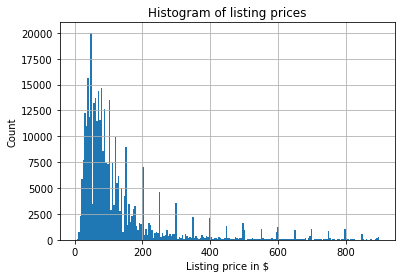

In [108]:
df1.loc[(df1.Price <= 900) & (df1.Price > 0)].Price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices');

In [109]:
df1['Property_Type'].head()

0    Apartment
1    Apartment
2    Apartment
3    Apartment
4        House
Name: Property_Type, dtype: object

In [115]:
df_temp=df1.Property_Type.value_counts().reset_index()

In [125]:
drop_data_property=np.unique(df_temp[df_temp['Property_Type']<10]['index'])

In [126]:
df1a=df1[~df1['Property_Type'].isin(drop_data_property)]

In [127]:
df1a.shape

(440731, 64)

In [111]:
## Remove entries where data count is less than 10

In [128]:
df1a['Room_Type'].value_counts()

Entire home/apt    279891
Private room       152851
Shared room          7989
Name: Room_Type, dtype: int64

In [130]:
df1a['Bed_Type'].value_counts()

Real Bed         425801
Pull-out Sofa      8651
Futon              3239
Couch              1834
Airbed             1206
Name: Bed_Type, dtype: int64

In [111]:
## clean amenities

In [131]:
df1a.Amenities = df1a.Amenities.str.replace("[{}]", "").str.replace('"', "")

In [132]:
df1a['Amenities'].tail(5)

100698    TV,Wireless Internet,Kitchen,Heating,Family/ki...
100699    Internet,Wireless Internet,Kitchen,Elevator in...
100700    TV,Internet,Wireless Internet,Air conditioning...
100701    TV,Cable TV,Internet,Wireless Internet,Wheelch...
100702    TV,Cable TV,Internet,Wireless Internet,Elevato...
Name: Amenities, dtype: object

In [133]:
## model now

In [135]:
##remove all NANs
df11=df1a[~df1a['Amenities'].isnull()]

In [136]:
print(df1a.shape)
print(df11.shape)

(440731, 64)
(437421, 64)


In [137]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(df11['Amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)

In [139]:
df11.columns.values

array(['Access', 'Accommodates', 'Amenities', 'Availability_30',
       'Availability_365', 'Availability_60', 'Availability_90',
       'Bathrooms', 'Bed_Type', 'Bedrooms', 'Beds',
       'Calculated_host_listings_count', 'Calendar_Updated',
       'Calendar_last_Scraped', 'Cancellation_Policy', 'City',
       'Cleaning_Fee', 'Country', 'Country_Code', 'Description',
       'Experiences_Offered', 'Extra_People', 'Features', 'First_Review',
       'Geolocation', 'Guests_Included', 'Host_About',
       'Host_Listings_Count', 'Host_Location', 'Host_Name',
       'Host_Neighbourhood', 'Host_Response_Rate', 'Host_Response_Time',
       'Host_Since', 'Host_Total_Listings_Count', 'House_Rules', 'ID',
       'Interaction', 'Last_Review', 'Latitude', 'Listing_Type',
       'Longitude', 'Market', 'Maximum_Nights', 'Minimum_Nights', 'Name',
       'Neighborhood_Overview', 'Neighbourhood', 'Neighbourhood_Cleansed',
       'Number_of_Reviews', 'Price', 'Property_Type', 'Rating\r',
       'Reviews_

In [140]:
#df11['Security_Deposit'] = df11['Security_Deposit'].fillna(value=0)
#df11['Security_Deposit'] = df11['Security_Deposit'].replace( '[\$,)]','', regex=True ).astype(float)
df11['Cleaning_Fee'] = df11['Cleaning_Fee'].fillna(value=0)
df11['Cleaning_Fee'] = df11['Cleaning_Fee'].replace( '[\$,)]','', regex=True ).astype(float)

In [141]:
def show_data(df,col):
    print(df[col].head(20))

In [142]:
df11.Features = df11.Features.str.replace("[{}]", "").str.replace('"', "")

In [143]:
feat=set()

In [144]:
for i,row in df11.iterrows():
    if pd.notna(row['Features']):
        l=row['Features'].split(',')
        for j in l:
            feat.add(j)

In [145]:
feat

{'Host Has Profile Pic',
 'Host Identity Verified',
 'Host Is Superhost',
 'Instant Bookable',
 'Is Location Exact',
 'Require Guest Phone Verification',
 'Require Guest Profile Picture',
 'Requires License'}

In [146]:
df12=df11.copy()

In [147]:
df12['Host Identity Verified']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Identity Verified' in x['Features'] else 0, axis=1)
df12['Host Has Profile Pic']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Has Profile Pic' in x['Features'] else 0, axis=1)
df12['Host Is Superhost']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Is Superhost' in x['Features'] else 0, axis=1)
df12['Instant Bookable']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Instant Bookable' in x['Features'] else 0, axis=1)
df12['Is Location Exact']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Is Location Exact' in x['Features'] else 0, axis=1)
df12['Require Guest Phone Verification']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Require Guest Phone Verification' in x['Features'] else 0, axis=1)
df12['Requires License']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Requires License' in x['Features'] else 0, axis=1)

In [148]:
df12['Host Has Profile Pic'].value_counts()

1    357912
0     79509
Name: Host Has Profile Pic, dtype: int64

In [149]:
df12.columns.values

array(['Access', 'Accommodates', 'Amenities', 'Availability_30',
       'Availability_365', 'Availability_60', 'Availability_90',
       'Bathrooms', 'Bed_Type', 'Bedrooms', 'Beds',
       'Calculated_host_listings_count', 'Calendar_Updated',
       'Calendar_last_Scraped', 'Cancellation_Policy', 'City',
       'Cleaning_Fee', 'Country', 'Country_Code', 'Description',
       'Experiences_Offered', 'Extra_People', 'Features', 'First_Review',
       'Geolocation', 'Guests_Included', 'Host_About',
       'Host_Listings_Count', 'Host_Location', 'Host_Name',
       'Host_Neighbourhood', 'Host_Response_Rate', 'Host_Response_Time',
       'Host_Since', 'Host_Total_Listings_Count', 'House_Rules', 'ID',
       'Interaction', 'Last_Review', 'Latitude', 'Listing_Type',
       'Longitude', 'Market', 'Maximum_Nights', 'Minimum_Nights', 'Name',
       'Neighborhood_Overview', 'Neighbourhood', 'Neighbourhood_Cleansed',
       'Number_of_Reviews', 'Price', 'Property_Type', 'Rating\r',
       'Reviews_

In [191]:
df13 = df12[['Host Has Profile Pic', 'Host Identity Verified', 'Host Is Superhost','Instant Bookable', 
                         'Is Location Exact', 'Require Guest Phone Verification', 'Requires License', 
                     'Guests_Included','Calculated_host_listings_count','Accommodates',
                           'Cleaning_Fee', 'Extra_People',
                         'Host_Listings_Count', 'Host_Total_Listings_Count', 'Minimum_Nights','Maximum_Nights','Beds',
                     'Bathrooms', 'Bedrooms', 'Number_of_Reviews', 'Price',
            'Availability_30',
       'Availability_60', 'Availability_90', 'Availability_365']]

In [304]:
df12.ID.dtype

dtype('float64')

In [192]:
for col in df13.columns[df13.isnull().any()]:
    print(col)

Calculated_host_listings_count
Accommodates
Extra_People
Host_Listings_Count
Host_Total_Listings_Count
Beds
Bathrooms
Bedrooms
Price


In [193]:
for col in df13.columns[df13.isnull().any()]:
    df13[col] = df13[col].fillna(df13[col].median())

In [194]:
for cat_feature in ['Property_Type', 'Cancellation_Policy', 'Bed_Type','Room_Type']:
    df13 = pd.concat([df13, pd.get_dummies(df12[cat_feature])], axis=1)

In [195]:
df13 = pd.concat([df13, df12['Listing_Type']], axis=1)

In [196]:
df13.shape

(437421, 79)

In [197]:
df_amenities.shape

(437421, 113)

In [219]:
df14 = pd.concat([df13, df_amenities], axis=1, join='inner')

In [220]:
df14a=pd.concat([df14, df12['type']], axis=1, join='inner')
print(df14a.shape)

(437421, 193)


In [221]:
df14a['Listing_Type'].value_counts()

Good    307192
Bad      30305
Name: Listing_Type, dtype: int64

In [222]:
df14a['Listing_Type']=df14a.apply(lambda x : 1 if x['Listing_Type']=='Good' else 0, axis=1) 

In [203]:
## Modelling

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score

In [224]:
df15=df14a[df14a['type']=='Train']
y = df15['Listing_Type']
x = df15.drop(['Listing_Type','type'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [225]:
## With Bootstrap without weight

In [226]:
rf =RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [227]:
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
#rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

#print('RMSE test: %.3f' % rmse_rf)
#print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Text(0.5,1,'Heat Map')

              precision    recall  f1-score   support

           0       0.58      0.39      0.47      6146
           1       0.94      0.97      0.96     61354

   micro avg       0.92      0.92      0.92     67500
   macro avg       0.76      0.68      0.71     67500
weighted avg       0.91      0.92      0.91     67500

F1 score for all clasess is  [0.4680975  0.95607965]
TP 59613
TN 2410
FP 3736
FN 1741


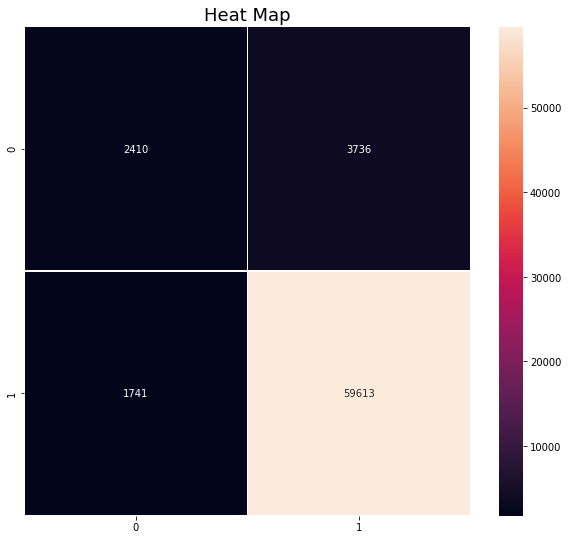

In [228]:
cnf_matrix=confusion_matrix(y_test,y_test_pred)
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
plt.title('Heat Map',fontsize=18)
#cmap="coolwarm_r"
print(classification_report(y_test,y_test_pred))
f1 = f1_score(y_test,y_test_pred,average=None)
#print("Iter & Depth is",(i,d))
print("F1 score for all clasess is ",f1)
print("TP",cnf_matrix[1,1,]) 
print("TN",cnf_matrix[0,0]) 
print("FP",cnf_matrix[0,1]) 
print("FN",cnf_matrix[1,0])

In [229]:
class_weight = dict({0:12,1:2})

In [230]:
rdf = RandomForestClassifier(bootstrap=True,
            class_weight=class_weight, 
            criterion='gini',
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500,
            oob_score=False,
            random_state=42,
            verbose=0, warm_start=False)

In [232]:
rdf.fit(X_train, y_train)
y_train_pred_rdf = rdf.predict(X_train)
y_test_pred_rdf = rdf.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight={0: 12, 1: 2},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)

Text(0.5,1,'Heat Map')

              precision    recall  f1-score   support

           0       0.54      0.69      0.61      6146
           1       0.97      0.94      0.95     61354

   micro avg       0.92      0.92      0.92     67500
   macro avg       0.76      0.82      0.78     67500
weighted avg       0.93      0.92      0.92     67500

F1 score for all clasess is  [0.60914939 0.95481365]
TP 57771
TN 4261
FP 1885
FN 3583


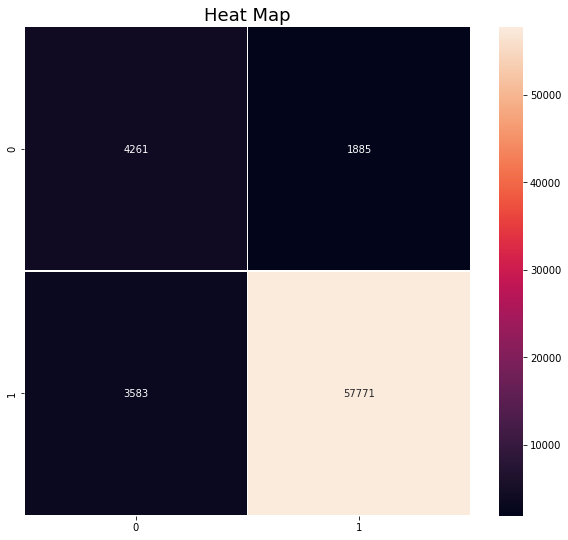

In [233]:
cnf_matrix=confusion_matrix(y_test,y_test_pred_rdf)
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
plt.title('Heat Map',fontsize=18)
#cmap="coolwarm_r"
print(classification_report(y_test,y_test_pred_rdf))
f1 = f1_score(y_test,y_test_pred_rdf,average=None)
#print("Iter & Depth is",(i,d))
print("F1 score for all clasess is ",f1)
print("TP",cnf_matrix[1,1,]) 
print("TN",cnf_matrix[0,0]) 
print("FP",cnf_matrix[0,1]) 
print("FN",cnf_matrix[1,0])

In [234]:
## Gradient Boosting

In [242]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=400, random_state=42, eval_metric=["auc", "error", "error@0.6"])

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_test_pred_xgb = xgb_model.predict(X_test)

[0]	validation_0-auc:0.912771	validation_0-error:0.082326	validation_0-error@0.6:0.908948
[1]	validation_0-auc:0.912771	validation_0-error:0.082326	validation_0-error@0.6:0.908948
[2]	validation_0-auc:0.914461	validation_0-error:0.082326	validation_0-error@0.6:0.108148
[3]	validation_0-auc:0.914461	validation_0-error:0.082326	validation_0-error@0.6:0.108148
[4]	validation_0-auc:0.914461	validation_0-error:0.082326	validation_0-error@0.6:0.082326
[5]	validation_0-auc:0.914461	validation_0-error:0.082326	validation_0-error@0.6:0.082326
[6]	validation_0-auc:0.914842	validation_0-error:0.082326	validation_0-error@0.6:0.082326
[7]	validation_0-auc:0.917372	validation_0-error:0.082326	validation_0-error@0.6:0.082326
[8]	validation_0-auc:0.921249	validation_0-error:0.082326	validation_0-error@0.6:0.082326
[9]	validation_0-auc:0.92134	validation_0-error:0.077674	validation_0-error@0.6:0.082326
[10]	validation_0-auc:0.921331	validation_0-error:0.077674	validation_0-error@0.6:0.082326
[11]	valid

[91]	validation_0-auc:0.9328	validation_0-error:0.075763	validation_0-error@0.6:0.077585
[92]	validation_0-auc:0.932836	validation_0-error:0.075748	validation_0-error@0.6:0.077541
[93]	validation_0-auc:0.932847	validation_0-error:0.075748	validation_0-error@0.6:0.077674
[94]	validation_0-auc:0.932861	validation_0-error:0.075778	validation_0-error@0.6:0.077585
[95]	validation_0-auc:0.932892	validation_0-error:0.075704	validation_0-error@0.6:0.077541
[96]	validation_0-auc:0.932936	validation_0-error:0.0756	validation_0-error@0.6:0.077556
[97]	validation_0-auc:0.932976	validation_0-error:0.075541	validation_0-error@0.6:0.077556
[98]	validation_0-auc:0.93307	validation_0-error:0.075526	validation_0-error@0.6:0.077467
[99]	validation_0-auc:0.933091	validation_0-error:0.075526	validation_0-error@0.6:0.077407
[100]	validation_0-auc:0.93313	validation_0-error:0.075481	validation_0-error@0.6:0.077407
[101]	validation_0-auc:0.933238	validation_0-error:0.075481	validation_0-error@0.6:0.077393
[10

[181]	validation_0-auc:0.935155	validation_0-error:0.075126	validation_0-error@0.6:0.076889
[182]	validation_0-auc:0.93516	validation_0-error:0.075126	validation_0-error@0.6:0.076889
[183]	validation_0-auc:0.935153	validation_0-error:0.075141	validation_0-error@0.6:0.076904
[184]	validation_0-auc:0.935161	validation_0-error:0.075081	validation_0-error@0.6:0.076874
[185]	validation_0-auc:0.93517	validation_0-error:0.075111	validation_0-error@0.6:0.076859
[186]	validation_0-auc:0.935174	validation_0-error:0.075111	validation_0-error@0.6:0.07683
[187]	validation_0-auc:0.935184	validation_0-error:0.07517	validation_0-error@0.6:0.076815
[188]	validation_0-auc:0.935203	validation_0-error:0.07517	validation_0-error@0.6:0.076844
[189]	validation_0-auc:0.935216	validation_0-error:0.075126	validation_0-error@0.6:0.076844
[190]	validation_0-auc:0.935231	validation_0-error:0.075126	validation_0-error@0.6:0.07677
[191]	validation_0-auc:0.935225	validation_0-error:0.075111	validation_0-error@0.6:0.0

[271]	validation_0-auc:0.935736	validation_0-error:0.075126	validation_0-error@0.6:0.07677
[272]	validation_0-auc:0.935733	validation_0-error:0.075067	validation_0-error@0.6:0.076785
[273]	validation_0-auc:0.935736	validation_0-error:0.075067	validation_0-error@0.6:0.076741
[274]	validation_0-auc:0.935766	validation_0-error:0.075067	validation_0-error@0.6:0.076726
[275]	validation_0-auc:0.935766	validation_0-error:0.075052	validation_0-error@0.6:0.076726
[276]	validation_0-auc:0.935773	validation_0-error:0.075096	validation_0-error@0.6:0.07677
[277]	validation_0-auc:0.935769	validation_0-error:0.075096	validation_0-error@0.6:0.076726
[278]	validation_0-auc:0.935771	validation_0-error:0.075067	validation_0-error@0.6:0.076652
[279]	validation_0-auc:0.935778	validation_0-error:0.075037	validation_0-error@0.6:0.076637
[280]	validation_0-auc:0.93578	validation_0-error:0.075037	validation_0-error@0.6:0.076622
[281]	validation_0-auc:0.935789	validation_0-error:0.075067	validation_0-error@0.6:

[361]	validation_0-auc:0.93627	validation_0-error:0.074696	validation_0-error@0.6:0.076696
[362]	validation_0-auc:0.936269	validation_0-error:0.074726	validation_0-error@0.6:0.076681
[363]	validation_0-auc:0.93628	validation_0-error:0.074667	validation_0-error@0.6:0.076607
[364]	validation_0-auc:0.936294	validation_0-error:0.074681	validation_0-error@0.6:0.076622
[365]	validation_0-auc:0.936296	validation_0-error:0.074681	validation_0-error@0.6:0.076622
[366]	validation_0-auc:0.936297	validation_0-error:0.074681	validation_0-error@0.6:0.076622
[367]	validation_0-auc:0.936294	validation_0-error:0.074696	validation_0-error@0.6:0.076637
[368]	validation_0-auc:0.936297	validation_0-error:0.074681	validation_0-error@0.6:0.076593
[369]	validation_0-auc:0.936294	validation_0-error:0.074652	validation_0-error@0.6:0.076622
[370]	validation_0-auc:0.936298	validation_0-error:0.074741	validation_0-error@0.6:0.076622
[371]	validation_0-auc:0.936303	validation_0-error:0.074741	validation_0-error@0.6

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric=['auc', 'error', 'error@0.6'],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Text(0.5,1,'Heat Map')

              precision    recall  f1-score   support

           0       0.61      0.50      0.55      6146
           1       0.95      0.97      0.96     61354

   micro avg       0.93      0.93      0.93     67500
   macro avg       0.78      0.73      0.75     67500
weighted avg       0.92      0.93      0.92     67500

F1 score for all clasess is  [0.54857143 0.95915994]
TP 59372
TN 3072
FP 3074
FN 1982


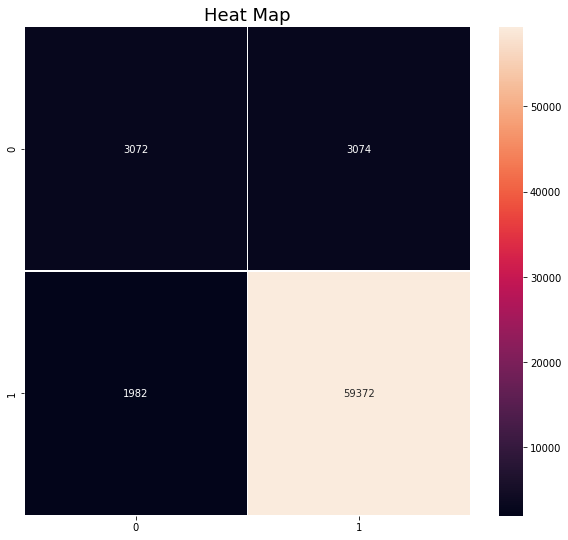

In [244]:
#y_train_pred_xgb = xgb.predict(X_train)
#y_test_pred_xgb = xgb.predict(X_test)

cnf_matrix=confusion_matrix(y_test,y_test_pred_xgb)
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
plt.title('Heat Map',fontsize=18)
#cmap="coolwarm_r"
print(classification_report(y_test,y_test_pred_xgb))
f1 = f1_score(y_test,y_test_pred_xgb,average=None)
#print("Iter & Depth is",(i,d))
print("F1 score for all clasess is ",f1)
print("TP",cnf_matrix[1,1,]) 
print("TN",cnf_matrix[0,0]) 
print("FP",cnf_matrix[0,1]) 
print("FN",cnf_matrix[1,0])

In [246]:
y_train_pred_xgb = xgb_model.predict(X_train)

In [289]:
y_train_predp=rf.predict_proba(X_train)
y_train_pred_rdfp=rdf.predict_proba(X_train)
y_train_pred_xgbp=xgb_model.predict_proba(X_train)

In [292]:
y_train_pred_xgbp

array([[1.01164877e-01, 8.98835123e-01],
       [9.58025455e-04, 9.99041975e-01],
       [6.29127026e-04, 9.99370873e-01],
       ...,
       [4.94122505e-04, 9.99505877e-01],
       [4.99725342e-04, 9.99500275e-01],
       [1.37094855e-02, 9.86290514e-01]], dtype=float32)

In [ ]:
y_test_predp=rf.predict_proba(X_test)
y_test_pred_rdfp=rdf.predict_proba(X_test)
y_test_pred_xgbp=xgb_model.predict_proba(X_test)

In [245]:
## creating an ensemble 

In [256]:
X_train.shape
y_train_pred.shape
y_train_pred_rdf.shape
y_train_pred_xgb.shape

(269997, 191)

(269997,)

(269997,)

(269997,)

In [286]:
#df_tr=pd.concat([X_train, pd.DataFrame(y_train_pred).reset_index(),pd.DataFrame(y_train_pred_rdf).reset_index(),pd.DataFrame(y_train_pred_xgb).reset_index()],axis=1)
#df_tr=pd.concat([X_train,pd.Series(list(y_train_pred))],axis=1)
df_tr=pd.DataFrame(np.hstack([X_train,pd.DataFrame(y_train_pred),pd.DataFrame(y_train_pred_rdf),pd.DataFrame(y_train_pred_xgb)]))
cols=list(X_train.columns)
cols.append('pred from rf')
cols.append('pred from rf weight')
cols.append('pred from xgb')
df_tr.columns=cols
#df_test_new=pd.concat([X_test, pd.DataFrame(y_test_pred),pd.DataFrame(y_test_pred_rdf),pd.DataFrame(y_test_pred_xgb)],axis=1)
df_te=pd.DataFrame(np.hstack([X_test,pd.DataFrame(y_test_pred),pd.DataFrame(y_test_pred_rdf),pd.DataFrame(y_test_pred_xgb)]))
cols=list(X_test.columns)
cols.append('pred from rf')
cols.append('pred from rf weight')
cols.append('pred from xgb')
df_te.columns=cols
#model = LogisticRegression()
#model.fit(df_train_new,y_train)
#model.score(df_train_new,y_test)

In [287]:
df_tr.shape
df_te.shape

(269997, 194)

(67500, 194)

In [288]:
model = LogisticRegression()
model.fit(df_tr,y_train)
model.score(df_te,y_test)
model.predict()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

0.9089481481481482

In [294]:
## use this model for prediction

In [299]:
def generatePredictions(df,rf,rdf,xgb_model,model):
    df1=df[df['type']=='Test']
    #y = df15['Listing_Type']
    x = df15.drop(['Listing_Type','type'], axis =1)
    y_train_pred=rf.predict(x)
    y_train_pred_rdf=rdf.predict(x)
    y_train_pred_xgb=xgb_model.predict(x)
    df_tr=pd.DataFrame(np.hstack([x,pd.DataFrame(y_train_pred),pd.DataFrame(y_train_pred_rdf),pd.DataFrame(y_train_pred_xgb)]))
    cols=list(x.columns)
    cols.append('pred from rf')
    cols.append('pred from rf weight')
    cols.append('pred from xgb')
    df_tr.columns=cols
    pred=model.predict(df_tr)
    df_return=pd.DataFrame(np.hstack([df_tr,pd.DataFrame(pred)]))
    cols=list(df_tr.columns)
    cols.append('pred from logistic model')
    df_return.columns=cols
    return df_return

In [300]:
results=generatePredictions(df14a,rf,rdf,xgb_model,model)

In [301]:
results.head()

Host Has Profile Pic  Host Identity Verified  Host Is Superhost  \
0                   1.0                     1.0                0.0   
1                   1.0                     0.0                0.0   
2                   1.0                     0.0                0.0   
3                   1.0                     0.0                0.0   
4                   1.0                     0.0                0.0   

   Instant Bookable  Is Location Exact  Require Guest Phone Verification  \
0               0.0                0.0                               0.0   
1               0.0                0.0                               0.0   
2               0.0                1.0                               0.0   
3               0.0                1.0                               0.0   
4               0.0                1.0                               0.0   

   Requires License  Guests_Included  Calculated_host_listings_count  \
0               1.0              1.0                             4.0   
1               0.0              1.0                             1.0   
2               0.0              1.0                             1.0   
3               0.0              1.0                             1.0   
4               1.0              1.0                             1.0   

   Accommodates  Cleaning_Fee  Extra_People  Host_Listings_Count  \
0           2.0           0.0           9.0                  4.0   
1           2.0         112.0           0.0                  1.0   
2           4.0          80.0           0.0                  1.0   
3           4.0           0.0           0.0                  1.0   
4           2.0           0.0           0.0                  2.0   

   Host_Total_Listings_Count  Minimum_Nights            ...              tv  \
0                        4.0             2.0            ...             1.0   
1                        1.0             1.0            ...             0.0   
2                        1.0             3.0            ...             1.0   
3                        1.0             5.0            ...             1.0   
4                        2.0             1.0            ...             0.0   

   washer  washer / dryer  waterfront  wheelchair accessible  \
0     1.0             0.0         0.0                    0.0   
1     1.0             0.0         0.0                    0.0   
2     1.0             0.0         0.0                    0.0   
3     1.0             0.0         0.0                    1.0   
4     0.0             0.0         0.0                    0.0   

   wide clearance to bed  wide clearance to shower and toilet  wide doorway  \
0                    0.0                                  0.0           0.0   
1                    0.0                                  0.0           0.0   
2                    0.0                                  0.0           0.0   
3                    0.0                                  0.0           0.0   
4                    0.0                                  0.0           0.0   

   wide hallway clearance  window guards  wireless internet  pred from rf  \
0                     0.0            0.0                1.0           1.0   
1                     0.0            0.0                0.0           1.0   
2                     0.0            0.0                1.0           1.0   
3                     0.0            0.0                1.0           0.0   
4                     0.0            0.0                1.0           0.0   

   pred from rf weight  pred from xgb  pred from logistic model  
0                  1.0            1.0                       1.0  
1                  1.0            1.0                       1.0  
2                  1.0            1.0                       1.0  
3                  0.0            0.0                       1.0  
4                  0.0            1.0                       1.0  

[5 rows x 195 columns]

In [247]:
## ensemble of 

In [ ]:
from imblearn.over_sampling import SMOTE

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_sample(df14.drop('Listing_Type', axis=1), df14['Listing_Type'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

In [259]:
oversampled_train.columns=df14.columns

In [261]:
oversampled_train.shape

(609902, 202)

In [180]:
##xgboost

In [181]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time


In [272]:
def data_processor(temp):
    df = temp.copy()
    df= df[df['type']=='Train']
    y = df['Listing_Type']
    x = df15.drop(['Listing_Type','type'], axis =1)
    df = temp.drop('Listing_Type', axis=1)
    #features_to_select = ['V14', 'V4', 'V17', 'V10', 'V12', 'V20', 'Amount', 'V21', 'V26', 'V28', 'V11', 'V19', 'V8', 'V7', 'V13']

    print('Use StandardScaler to process the column data')
    scaler = StandardScaler()
    df[df.columns[:-1].tolist()] = scaler.fit_transform(df[df.columns[:-1].tolist()])
    # print(df.head(5))
    X = df[df.columns[:-1].tolist()]
    X = X[features_to_select]
    y = df[df.columns[-1]]

    print("Train Test Split ratio is 0.3")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")

    return X_train, X_test, y_train, y_test

In [273]:
def randomForest():
    """
    F1 score is: 0.7857142857142857
    AUC Score is: 0.9450972761670293
    """
    X_train, X_test, y_train, y_test = data_processor()
    # parameters = {'n_estimators': [10, 20, 30, 50], 'max_depth': [2, 3, 4]}

    clf = RandomForestClassifier(max_depth=4, n_estimators=20)
    # clf = GridSearchCV(alg, parameters, n_jobs=4)
    clf.fit(X_train, y_train)
    print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    print("F1 score is: {}".format(f1_score(y_test, y_pred)))
    print("AUC Score is: {}".format(roc_auc_score(y_test, y_pred_proba)))

In [274]:
def logistic_regression():
    """
    F1 score is: 0.7285714285714285
    AUC Score is: 0.9667565771367231
    """
    X_train, X_test, y_train, y_test = data_processor()
    clf = LogisticRegression(C=1e5)
    clf.fit(X_train, y_train)

    print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    print("F1 score is: {}".format(f1_score(y_test, y_pred)))
    print("AUC Score is: {}".format(roc_auc_score(y_test, y_pred_proba)))

In [275]:
def logistic_with_smote():
    X_train, X_test, y_train, y_test = data_processor()

    clf = LogisticRegression(C=1e5)
    clf.fit(X_train, y_train)
    # build model with SMOTE imblearn
    smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), clf)

    smote_model = smote_pipeline.fit(X_train, y_train)
    smote_prediction = smote_model.predict(X_test)
    smote_prediction_proba = smote_model.predict_proba(X_test)[:, 1]

    print(classification_report_imbalanced(y_test, smote_prediction))
    print('SMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
    print("SMOTE AUC score: ", roc_auc_score(y_test, smote_prediction_proba))
    print("SMOTE F1 Score: ", f1_score(y_test, smote_prediction))


In [182]:
def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """
    
    ---------------------------------->
    # {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3} 0.862920874517388
    # {'colsample_bytree': 1.0, 'gamma': 0.2} 0.871
    # {'gamma': 0.2, 'scale_pos_weight': 1} 0.8702009952422571
    # {'subsample': 0.6} 0.864310306628855
    """
    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=42)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(X_test.values, label=y_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    print('Start Training')
    alg.fit(X_train, y_train, eval_metric='auc')

    # param_test1 = {}
    # gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
    #                                                 min_child_weight=3, gamma=0.2, subsample=0.8,
    #                                                 colsample_bytree=1.0,
    #                                                 objective='binary:logistic', nthread=4, scale_pos_weight=1,
    #                                                 seed=27),
    #                         param_grid=param_test1,
    #                         scoring='f1',
    #                         n_jobs=4, iid=False, cv=5)
    # gsearch1.fit(X_train, y_train)
    # print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

    print("Start Predicting")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]

    print("Accuracy: %.4g" % metrics.accuracy_score(y_test, predictions))
    print("AUC: %f" % metrics.roc_auc_score(y_test, pred_proba))
    print("F1 Score : %f" % metrics.f1_score(y_test, predictions))

    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    # clf.best_estimator_.booster().get_fscore()
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())

In [ ]:
alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=42)
print("Start Feeding Data")
xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=1,
                  early_stopping_rounds=50)
alg.set_params(n_estimators=cvresult.shape[0])

print('Start Training')
alg.fit(X_train, y_train, eval_metric='auc')

In [ ]:
### start here 

In [305]:
def predictListingType(csv_file):
    ## preprocess
    df_train,drop_cols=prepareTrainData(r'C:\Users\kishore.kukreja\Downloads\listings\listings.csv')
    df=pd.read_csv(csv_file,sep=';',lineterminator='\n')
    df['type']='Test'
    df_new=df.drop(drop_cols,axis=1)
    df_test=df_new.copy()
    df_test.rename(columns={'GUID':'ID'},inplace=True)
    df_total=pd.concat([df_train,df_test],axis=0)
    df_total=df_total[~df_total['Country'].isnull()]
    df1=df_total[~df_total['Description'].isnull()]
    df1['Price'] = df1['Price'].astype(float)
    df1['Price'].describe()
    df_temp=df1.Property_Type.value_counts().reset_index()
    drop_data_property=np.unique(df_temp[df_temp['Property_Type']<10]['index'])
    df1a=df1[~df1['Property_Type'].isin(drop_data_property)]
    print(df1a.shape)
    df1a.Amenities = df1a.Amenities.str.replace("[{}]", "").str.replace('"', "")
    df11=df1a[~df1a['Amenities'].isnull()]
    df11['Cleaning_Fee'] = df11['Cleaning_Fee'].fillna(value=0)
    df11['Cleaning_Fee'] = df11['Cleaning_Fee'].replace( '[\$,)]','', regex=True ).astype(float)
    df11.Features = df11.Features.str.replace("[{}]", "").str.replace('"', "")
    feat=set()
    for i,row in df11.iterrows():
        if pd.notna(row['Features']):
            l=row['Features'].split(',')
            for j in l:
                feat.add(j)
    df12=df11.copy()
    df12['Host Identity Verified']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Identity Verified' in x['Features'] else 0, axis=1)
    df12['Host Has Profile Pic']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Has Profile Pic' in x['Features'] else 0, axis=1)
    df12['Host Is Superhost']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Is Superhost' in x['Features'] else 0, axis=1)
    df12['Instant Bookable']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Instant Bookable' in x['Features'] else 0, axis=1)
    df12['Is Location Exact']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Is Location Exact' in x['Features'] else 0, axis=1)
    df12['Require Guest Phone Verification']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Require Guest Phone Verification' in x['Features'] else 0, axis=1)
    df12['Requires License']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Requires License' in x['Features'] else 0, axis=1)
    df13 = df12[['Host Has Profile Pic', 'Host Identity Verified', 'Host Is Superhost','Instant Bookable', 
                             'Is Location Exact', 'Require Guest Phone Verification', 'Requires License', 
                         'Guests_Included','Calculated_host_listings_count','Accommodates',
                               'Cleaning_Fee', 'Extra_People',
                             'Host_Listings_Count', 'Host_Total_Listings_Count', 'Minimum_Nights','Maximum_Nights','Beds',
                         'Bathrooms', 'Bedrooms', 'Number_of_Reviews', 'Price',
                'Availability_30',
           'Availability_60', 'Availability_90', 'Availability_365','ID']]

    for col in df13.columns[df13.isnull().any()]:
        df13[col] = df13[col].fillna(df13[col].median())

    for cat_feature in ['Property_Type', 'Cancellation_Policy', 'Bed_Type','Room_Type']:
        df13 = pd.concat([df13, pd.get_dummies(df12[cat_feature])], axis=1)

    df13 = pd.concat([df13, df12['Listing_Type']], axis=1)
    
    df_amenities=create_bow(df11,'Amenities')

    df14 = pd.concat([df13, df_amenities], axis=1, join='inner')

    df14a=pd.concat([df14, df12['type']], axis=1, join='inner')
    print(df14a.shape)

    df14a['Listing_Type']=df14a.apply(lambda x : 1 if x['Listing_Type']=='Good' else 0, axis=1) 
   
    return df14a

In [303]:
def create_bow(df,col):
    from sklearn.feature_extraction.text import CountVectorizer
    count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
    amenities = count_vectorizer.fit_transform(df[col])
    df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
    df_amenities = df_amenities.drop('',1)
    return df_amenities

In [ ]:
predictListingType(r'C:\Users\kishore.kukreja\Downloads\listings_test_send\listings_test_send.csv')

In [ ]:
def apply_models()

In [ ]:




df15=df14a[df14a['type']=='Train']
y = df15['Listing_Type']
x = df15.drop(['Listing_Type','type'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

rf =RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

## Print with RF Normal
cnf_matrix=confusion_matrix(y_test,y_test_pred)
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
plt.title('Heat Map',fontsize=18)
#cmap="coolwarm_r"
print(classification_report(y_test,y_test_pred))
f1 = f1_score(y_test,y_test_pred,average=None)
#print("Iter & Depth is",(i,d))
print("F1 score for all clasess is ",f1)
print("TP",cnf_matrix[1,1,]) 
print("TN",cnf_matrix[0,0]) 
print("FP",cnf_matrix[0,1]) 
print("FN",cnf_matrix[1,0])

class_weight = dict({0:12,1:2})
rdf = RandomForestClassifier(bootstrap=True,
            class_weight=class_weight, 
            criterion='gini',
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500,
            oob_score=False,
            random_state=42,
            verbose=0, warm_start=False)

rdf.fit(X_train, y_train)
y_train_pred_rdf = rdf.predict(X_train)
y_test_pred_rdf = rdf.predict(X_test)
print('With RF Weighted')
cnf_matrix=confusion_matrix(y_test,y_test_pred_rdf)
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
plt.title('Heat Map',fontsize=18)
#cmap="coolwarm_r"
print(classification_report(y_test,y_test_pred_rdf))
f1 = f1_score(y_test,y_test_pred_rdf,average=None)
#print("Iter & Depth is",(i,d))
print("F1 score for all clasess is ",f1)
print("TP",cnf_matrix[1,1,]) 
print("TN",cnf_matrix[0,0]) 
print("FP",cnf_matrix[0,1]) 
print("FN",cnf_matrix[1,0])


xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=400, random_state=42, eval_metric=["auc", "error", "error@0.6"])

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

print('with XGB')
cnf_matrix=confusion_matrix(y_test,y_test_pred_xgb)
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
plt.title('Heat Map',fontsize=18)
#cmap="coolwarm_r"
print(classification_report(y_test,y_test_pred_xgb))
f1 = f1_score(y_test,y_test_pred_xgb,average=None)
#print("Iter & Depth is",(i,d))
print("F1 score for all clasess is ",f1)
print("TP",cnf_matrix[1,1,]) 
print("TN",cnf_matrix[0,0]) 
print("FP",cnf_matrix[0,1]) 
print("FN",cnf_matrix[1,0])

df_tr=pd.DataFrame(np.hstack([X_train,pd.DataFrame(y_train_pred),pd.DataFrame(y_train_pred_rdf),pd.DataFrame(y_train_pred_xgb)]))
cols=list(X_train.columns)
cols.append('pred from rf')
cols.append('pred from rf weight')
cols.append('pred from xgb')
df_tr.columns=cols
#df_test_new=pd.concat([X_test, pd.DataFrame(y_test_pred),pd.DataFrame(y_test_pred_rdf),pd.DataFrame(y_test_pred_xgb)],axis=1)
df_te=pd.DataFrame(np.hstack([X_test,pd.DataFrame(y_test_pred),pd.DataFrame(y_test_pred_rdf),pd.DataFrame(y_test_pred_xgb)]))
cols=list(X_test.columns)
cols.append('pred from rf')
cols.append('pred from rf weight')
cols.append('pred from xgb')
df_te.columns=cols


model = LogisticRegression()
model.fit(df_tr,y_train)
model.score(df_te,y_test)

return rf,rdf,xgb_model,model